## Importing and Processing Data

In [1]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPooling2D, AveragePooling2D,GlobalAveragePooling2D, GlobalMaxPooling2D,Dropout, Flatten, Dense
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import os

In [2]:
path="../input/facial-age/face_age/"

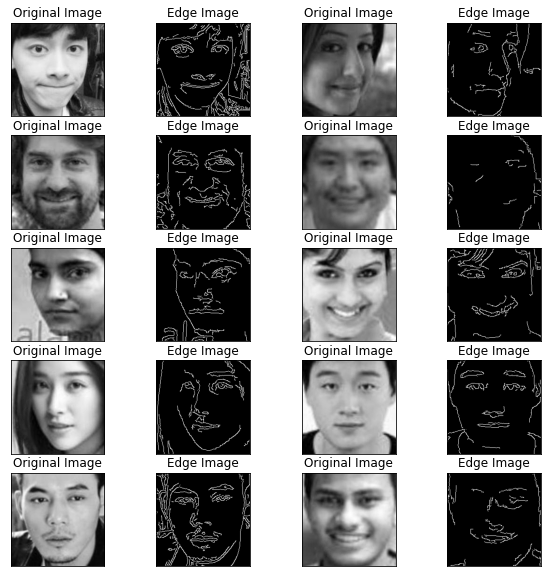

In [3]:
# Visualization of images

def visualize_image(age, number_of_images):
    plt.figure(figsize=(10, 10))
    folder=path+age+'/'
    images=os.listdir(folder)[:number_of_images]
    for i in range(number_of_images):
        img = cv2.imread(folder+images[i], 0)
        
        highThresh, thresh_im = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        lowThresh = 0.5*highThresh
        edges = cv2.Canny(img, lowThresh, highThresh)
        
#         v = np.median(img)
#         sigma = 0.33
#         lower = int(max(0, (1.0 - sigma) * v))
#         upper = int(min(255, (1.0 + sigma) * v))
#         edges = cv2.Canny(img, lower, upper)

        plt.subplot(number_of_images//2, 4, 2*i+1),plt.imshow(img, cmap = 'gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(number_of_images//2, 4, 2*i+2),plt.imshow(edges, cmap = 'gray')
        plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

visualize_image("026", 10)

In [4]:
X=[]
y=[]

for folder, _, imgs in os.walk(path):
    if folder!="face_age":
        for img in imgs:
            img_path=folder+'/'+img
            image = cv2.imread(img_path, 0)
            
            highThresh, thresh_im = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            lowThresh = 0.5*highThresh
            edges = cv2.Canny(image, lowThresh, highThresh)
            
            X.append(np.array(edges))
            y.append(int(folder[-3:]))

X=np.array(X)
y=np.array(y);

In [5]:
X=X.astype("float32")
#normalization
X /= 255.0
y = y//20 #dividing in range of 20

In [6]:
X = X.reshape(X.shape[0], 200, 200, 1)
X.shape

(19556, 200, 200, 1)

In [7]:
pd.DataFrame(y)[0].unique()

array([2, 4, 3, 0, 1, 5])

In [8]:
y = to_categorical(y, num_classes=6)

In [9]:
# os.mkdir("../dataset/Data")

In [10]:
# np.save("../dataset/face_age_data/X.npy", X)
# np.save("../dataset/face_age_data/y.npy", y)
# X = np.load('../dataset/face_age_data/X.npy')
# y = np.load('../dataset/face_age_data/y.npy')

## Train, Test and Validation Datasets

In [11]:
# Train, validation and testing split

test_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=True, stratify=y)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [12]:
# save to files
# np.save('../dataset/face_age_data/X_train.npy', X_train)
# np.save('../dataset/face_age_data/y_train.npy', y_train)
# np.save('../dataset/face_age_data/X_val.npy', X_val)
# np.save('../dataset/face_age_data/y_val.npy', y_val)
# np.save('../dataset/face_age_data/X_test.npy', X_test)
# np.save('../dataset/face_age_data/y_test.npy', y_test)

# X_train = np.load('../dataset/face_age_data/X_train.npy')
# y_train = np.load('../dataset/face_age_data/y_train.npy')
# X_val = np.load('../dataset/face_age_data/X_val.npy')
# y_val = np.load('../dataset/face_age_data/y_val.npy')
# X_test = np.load('../dataset/face_age_data/X_test.npy')
# y_test = np.load('../dataset/face_age_data/y_test.npy')

In [13]:
# confirm the saved files
# os.listdir("../face_age_dataset/Data")

## Image Augmentation

In [14]:
# Apply Image Augmentation

train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2, 
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

## Callbacks and Default Hyperparameters

In [15]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=6, # wait for 6 epochs
                                min_delta = 0.01, # if in 6 epochs the loss function doesn't increase (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, # if val_loss plateaus for 3 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

        
# hyperparameters
lr = 0.01
epochs = 100
batch_size = 128
results = {}
input_shape =[200, 200]

## CNN Model

In [16]:
def baseline_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.4))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    return model

In [17]:
filepath = './cnn_face-age__relu-softmax_Canny_AgeRange-20.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, mode="min", verbose=1)

In [18]:
# Adam= keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9, beta_2=0.999, decay=0.0)

In [19]:
model = baseline_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

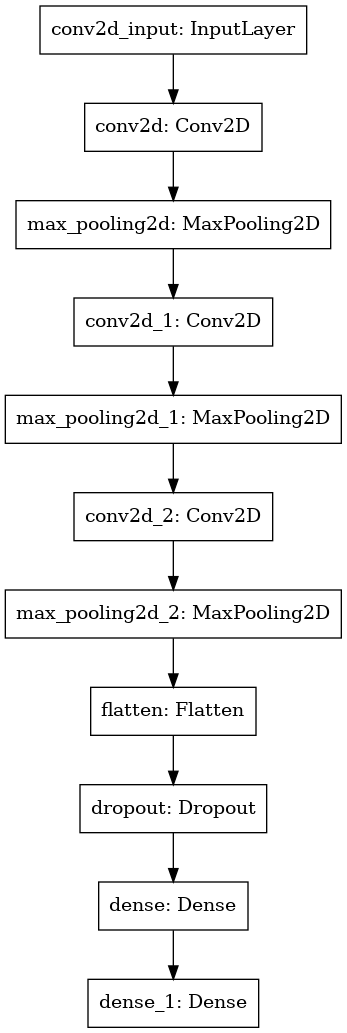

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./cnn_facial_age-relu-softmax_Canny_AgeRange-20.png')

In [21]:
model.fit(
    train_datagen.flow(
        X_train, y_train,
        batch_size = batch_size
    ), # use augmented images
    validation_data = (X_test, y_test),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs = epochs,
    callbacks = [
                    reduce_learning_rate,
                    early_stopping,
                    time_callback,
                    checkpoint
                ],
    verbose=True)

2021-12-05 13:28:07.681033: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
122/122 [==============================] - 346s 3s/step - loss: 1.0519 - accuracy: 0.5708 - mae: 0.1791 - val_loss: 0.8872 - val_accuracy: 0.6217 - val_mae: 0.1492

Epoch 00001: val_loss improved from inf to 0.88718, saving model to ./cnn_face-age__relu-softmax_Canny_AgeRange-20.epoch01-loss0.89.hdf5
Epoch 2/100
122/122 [==============================] - 345s 3s/step - loss: 0.8889 - accuracy: 0.6350 - mae: 0.1548 - val_loss: 0.8254 - val_accuracy: 0.6608 - val_mae: 0.1333

Epoch 00002: val_loss improved from 0.88718 to 0.82540, saving model to ./cnn_face-age__relu-softmax_Canny_AgeRange-20.epoch02-loss0.83.hdf5
Epoch 3/100
122/122 [==============================] - 344s 3s/step - loss: 0.8098 - accuracy: 0.6661 - mae: 0.1432 - val_loss: 0.7566 - val_accuracy: 0.6802 - val_mae: 0.1305

Epoch 00003: val_loss improved from 0.82540 to 0.75656, saving model to ./cnn_face-age__relu-softmax_Canny_AgeRange-20.epoch03-loss0.76.hdf5
Epoch 4/100
122/122 [=============================

In [22]:
baseline_adam_train_loss = model.history.history["loss"]
baseline_adam_val_loss = model.history.history["val_loss"]
baseline_adam_train_acc = model.history.history["mae"]
baseline_adam_val_acc = model.history.history["val_mae"]

results["baseline_adam"] = {'train-loss': baseline_adam_train_loss,
                             'val-loss': baseline_adam_val_loss,
                             'train-mae': baseline_adam_train_acc,
                             'val-mae': baseline_adam_val_acc}

## Performance Visualization

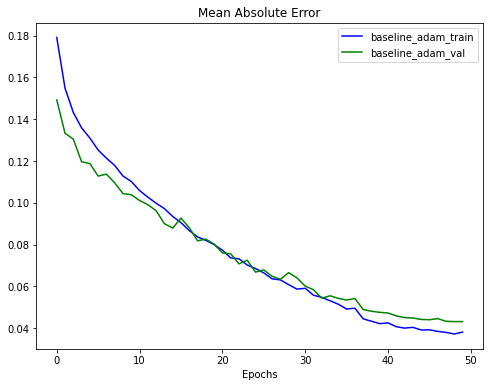

In [23]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-mae'])),results[cond]['train-mae'], '-', label=cond+"_train", color="blue")
    plt.plot(range(len(results[cond]['val-mae'])),results[cond]['val-mae'], '-', label=cond+"_val", color="green")
plt.title("Mean Absolute Error")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Results on Test Set

In [24]:
model_test_results = model.evaluate(X_test, y_test, batch_size=128)
dict(zip(model.metrics_names, model_test_results))

31/31 [==============================] - 17s 535ms/step - loss: 0.3324 - accuracy: 0.9013 - mae: 0.0432


{'loss': 0.3324202299118042,
 'accuracy': 0.9013292193412781,
 'mae': 0.043211258947849274}

In [25]:
from tensorflow.math import argmax

In [26]:
y_pred = argmax(model.predict(X_test), axis=1)

## Performance in Age Range of 20

Text(0.5, 1.0, 'Predicted vs Original')

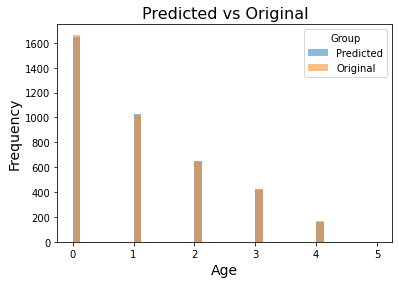

In [27]:
pd.Series((y_pred)).plot(kind='hist', bins=40, label='Predicted', alpha=0.5)
pd.Series(argmax(y_test, axis = 1)).plot(kind='hist', bins=40, label='Original', alpha=0.5)

plt.legend(title='Group')

plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.title('Predicted vs Original', fontsize=16)

<AxesSubplot:>

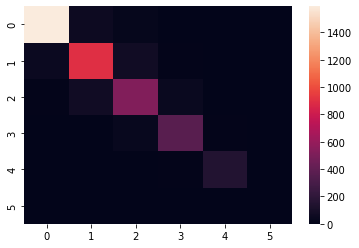

In [28]:
import seaborn as sns
sns.heatmap(confusion_matrix(argmax(y_test, axis = 1), y_pred))

In [29]:
print(classification_report(argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1666
           1       0.87      0.88      0.88      1021
           2       0.80      0.81      0.80       645
           3       0.86      0.88      0.87       414
           4       0.94      0.90      0.92       164
           5       1.00      1.00      1.00         2

    accuracy                           0.90      3912
   macro avg       0.91      0.90      0.91      3912
weighted avg       0.90      0.90      0.90      3912

